In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import seaborn as sns

resultado_anterior = 0

In [91]:
def modelfit(model, features, labels, usarCrossValidation=True, cv_folds=5, early_stopping_rounds=50):
    if usarCrossValidation:
        parametros = model.get_xgb_params()
        dmatrix = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(parametros, dmatrix, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=True, early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
    
    model.fit(features, labels,eval_metric='auc')
    
def obtener_marca(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(prefix + modelo.split()[0])
    return r

def obtenerRes(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append(np.NaN)
        else:
            r.append(prefix + modelo.split("x")[0])
    return r

### Lectura csv

In [4]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

### Creacion de features

In [135]:
#
###                               CREACION DF PREDICTOR
#

dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#
###                               FILTRADO DE FECHAS
#

antesDeMayo = df.loc[df['timestamp'] < pd.to_datetime('01-05-2018')]
ult30Dias = df.loc[(df['timestamp'] > pd.to_datetime('01-05-2018'))]# & (df['timestamp'] > pd.to_datetime('15-05-2018'))]
ult15Dias = df.loc[(df['timestamp'] > pd.to_datetime('15-05-2018'))]# & (df['timestamp'] > pd.to_datetime('25-05-2018'))]
ult5Dias = df.loc[(df['timestamp'] > pd.to_datetime('25-05-2018'))]# & (df['timestamp'] > pd.to_datetime('31-05-2018'))]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]

#
###                               CREACION DE FEATURES
#

#
##  POR EVENTO


#  CHECKOUTS

checkoutsPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaAntesDeMayo.columns = ['checkoutsPorPersonaAntesDeMayo']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']


dfPredictor = dfPredictor.join(checkoutsPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  CONVERSIONES

conversionesPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
conversionesPorPersonaAntesDeMayo.columns = ['conversionesPorPersonaAntesDeMayo']

conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

dfPredictor = dfPredictor.join(conversionesPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  VISITAS

visitasUlt15DiasPorPersona = ult15Dias.loc[ult15Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt15DiasPorPersona.columns = ['CantVisitasUlt15Dias']

visitasUlt5DiasPorPersona = ult5Dias.loc[ult5Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt5DiasPorPersona.columns = ['CantVisitasUlt5Dias']

visitasUltDiaPorPersona = ultDia.loc[ultDia['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUltDiaPorPersona.columns = ['CantVisitasUltDia']

dfPredictor = dfPredictor.join(visitasUlt15DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUlt5DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUltDiaPorPersona, how = 'left', on = 'person').fillna(value = 0)


#  VIEWED PRODUCT

viewedProductPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt15Dias.columns = ['viewedProductUlt15Dias']

viewedProductPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt5Dias.columns = ['viewedProductUlt5Dias']

viewedProductPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUltDia.columns = ['viewedProductUltDia']

dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### POR CANAL DE ORIGEN

visitasUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'visited site']
visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

#  PAGO

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)


#  ORGANIC

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)


#  DIRECT
directUlt30Dias = visitasUlt30Dias.loc[visitasUlt30Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt30Dias.columns = ['CanalDirectoUlt30Dias']

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']
#directUlt15Dias['CanalDirectoUlt15Dias'] = 1

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

dfPredictor = dfPredictor.join(directUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)


#  REFERRAL

referralUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt15Dias.columns = ['CanalReferidoUlt15Dias']

referralUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt5Dias.columns = ['CanalReferidoUlt5Dias']

referralUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUltDia.columns = ['CanalReferidoUltDia']

dfPredictor = dfPredictor.join(referralUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUltDia, how = 'left', on = 'person').fillna(value = 0)


#  SOCIAL

socialUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt15Dias.columns = ['CanalSocialUlt15Dias']

socialUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt5Dias.columns = ['CanalSocialUlt5Dias']

socialUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Social']['person'].value_counts().to_frame()
socialUltDia.columns = ['CanalSocialUltDia']

dfPredictor = dfPredictor.join(socialUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUltDia, how = 'left', on = 'person').fillna(value = 0)


#  EMAIL

emailUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt15Dias.columns = ['CanalEmailUlt15Dias']

emailUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt5Dias.columns = ['CanalEmailUlt5Dias']

emailUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Email']['person'].value_counts().to_frame()
emailUltDia.columns = ['CanalEmailUltDia']

dfPredictor = dfPredictor.join(emailUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### FEATURES AVANZADOS

#  CANTIDAD DE CHECKOUTS POR MARCA

#marcas = {'Samsung':'Samsung', 'Motorola':'Motorola', 'iPhone':'iPhone', 'LG':'LG', 'Sony':'Sony', 'Lenovo':'Lenovo','iPad':'iPad', 'Quantum':'Quantum', 'Asus':'Asus'}
prefijo = "total_checks_"
#marcas = {marca: prefijo + nombreFeature for marca, nombreFeature in marcas.items()}

total_checks = df.loc[df["event"]=="checkout"].copy()
total_checks["Marca"] = obtener_marca(total_checks["model"],prefijo)
#total_checks = total_checks.loc[(total_checks["Marca"]==marcas["iPhone"])|(total_checks["Marca"]==marcas["Samsung"])]
total_checks["contador"] = 1
total_checks=total_checks.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_checks, how = 'left', on = 'person').fillna(value = 0)

prefijo = "total_views_"
total_views = ult30Dias.loc[ult30Dias["event"]=="viewed product"].copy()
total_views["Marca"] = obtener_marca(total_views["model"],prefijo)
#total_views = total_views.loc[(total_views["Marca"]==marcas["iPhone"])|(total_views["Marca"]==marcas["Samsung"])]
total_views["contador"] = 1
total_views=total_views.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_views, how = 'left', on = 'person').fillna(value = 0)

## CANTIDAD DE BUSQUEADAS
name_feature1 = "cant_searchs_ult_30"
name_feature2 = "busco_ult_30"
cant_search = ult30Dias.loc[ult30Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_15"
name_feature2 = "busco_ult_15"
cant_search = ult15Dias.loc[ult15Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_5"
name_feature2 = "busco_ult_5"
cant_search = ult5Dias.loc[ult5Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_total"
name_feature2 = "busco_total"
cant_search = df.loc[df["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

# Primer ingreso
primer_ingreso = df.groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primerIngreso']
primer_ingreso['primerIngreso'] = primer_ingreso['primerIngreso'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultimo ingreso
ultimo_ingreso = df.groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimoIngreso']
ultimo_ingreso['ultimoIngreso'] = ultimo_ingreso['ultimoIngreso'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# Primer checkout
primer_ingreso = df[df['event'] == 'checkout'].groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primerCheckout']
primer_ingreso['primerCheckout'] = primer_ingreso['primerCheckout'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultimo checkout
ultimo_ingreso = df[df['event'] == 'checkout'].groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimoCheckout']
ultimo_ingreso['ultimoCheckout'] = ultimo_ingreso['ultimoCheckout'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# Primera conversion
primer_ingreso = df[df['event'] == 'conversion'].groupby("person")['timestamp'].min()
primer_ingreso = (pd.to_datetime("2018-06-01") - primer_ingreso).to_frame()
primer_ingreso.columns = ['primeraConversion']
primer_ingreso['primeraConversion'] = primer_ingreso['primeraConversion'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(primer_ingreso, how = 'left', on = 'person')

# Ultima conversion
ultimo_ingreso = df[df['event'] == 'conversion'].groupby("person")['timestamp'].max()
ultimo_ingreso = (pd.to_datetime("2018-06-01") - ultimo_ingreso).to_frame()
ultimo_ingreso.columns = ['ultimaConversion']
ultimo_ingreso['ultimaConversion'] = ultimo_ingreso['ultimaConversion'] // np.timedelta64(1, 'h')
dfPredictor = dfPredictor.join(ultimo_ingreso, how = 'left', on = 'person')

# region desde donde mas visita
region = df.loc[(df["event"] == "visited site") & (df['country'] == 'Brazil'), ['person','region']]
region = region
region["count"] =1
region = region.groupby(["person","region"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del region["count"]
region.set_index("person",inplace=True)
regionesNoBrasil = df.loc[(df["event"] == "visited site") & (df['country'] != 'Brazil')]['region'].unique()
region['region'].cat.remove_categories(regionesNoBrasil,inplace=True)
region = pd.get_dummies(region['region'])
dfPredictor = dfPredictor.join(region, how = 'left', on = 'person').fillna(value = 0)

# CONDICION

condicion = df.groupby('person')['condition'].value_counts().to_frame()
condicion.columns = ['cant']
condicion = condicion.reset_index()
condicion = condicion.pivot(columns='condition', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dfPredictor = dfPredictor.join(condicion, how = 'left', on = 'person').fillna(value = 0)

# DISPOSITIVO
dispositivo = df.groupby('person')['device_type'].value_counts().to_frame()
dispositivo.columns = ['cant']
dispositivo = dispositivo.reset_index()
dispositivo = dispositivo.pivot(columns='device_type', index='person', values='cant').fillna(0).rename_axis(None, axis=1)#.drop(['Unknown'], axis=1)
dfPredictor = dfPredictor.join(dispositivo, how = 'left', on = 'person').fillna(value = 0)

# SCREEN RESOLUTION

df["screenRes"] = obtenerRes(df['screen_resolution'])
screen = df.loc[df["screenRes"].notna(),["person", "screenRes"]].copy()
screen["screenRes"] = screen["screenRes"].astype(int)
screen["screenRes"] = np.where(screen["screenRes"].between(0,319), 200, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(320,359), 340, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(360,400), 380, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(401,600), 500, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(601,1000), 1000, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(1000,100000), 2000, screen["screenRes"])

screen = screen.groupby('person')['screenRes'].value_counts().to_frame()
screen.columns = ['cant']
screen = screen.reset_index()
screen["screenRes"] = screen["screenRes"].astype(str)
screen = screen.pivot(columns='screenRes', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dfPredictor = dfPredictor.join(screen, how = 'left', on = 'person').fillna(value = 0)

# Pais
pais = df.loc[df["event"] == "visited site", ['person','country']]
pais["count"] =1
pais = pais.groupby(["person","country"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del pais["count"]
pais["esDeBrasil"] = pais["country"] == "Brazil"
del pais["country"]
pais.set_index("person",inplace=True)
dfPredictor = dfPredictor.join(pais, how = 'left', on = 'person')
dfPredictor["esDeBrasil"].fillna(value = False,inplace=True)

#vieron
vieron_celular = df.loc[(df["event"] == "viewed product") & (df["model"] == "Samsung Galaxy J5"),["person"]]
vieron_celular["vieron_celular"] = 1
vieron_celular.set_index("person",inplace=True)
vieron_celular = vieron_celular[~vieron_celular.index.duplicated(keep='first')]
dfPredictor = dfPredictor.join(vieron_celular, how = 'left', on = 'person')
dfPredictor["vieron_celular"].fillna(value = 0,inplace=True)

### TEEEEEEEEEEST Cuantas veces hizo checkout de los 20 celus mas visitados
view_products = ult15Dias.loc[ult15Dias["event"] == "checkout",["model"]].copy()
view_products["Visitas"] = 1
phones20view = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(4).index.tolist()
checkouts = df.loc[df["event"]=="checkout",["person","model"]].copy()
def estaDentroDe(serie,lista):
    r = []
    for i in serie:
        if i in lista:
            r.append(True)
        else:
            r.append(False)
    return r
checkouts["model"] = estaDentroDe(checkouts["model"],phones20view)
checkouts= checkouts.groupby("person").agg("sum")
dfPredictor = dfPredictor.join(checkouts, how = 'left', on = 'person')
dfPredictor["model"].fillna(value = 0,inplace=True)

dfPredictor['regiones'] = dfPredictor['Ceara'] + dfPredictor['Santa Catarina'] + dfPredictor['Rio de Janeiro'] + dfPredictor['Sao Paulo'] +  dfPredictor['Rio Grande do Norte'] + dfPredictor['Rio Grande do Sul'] + dfPredictor['Maranhao'] 

### Agregado y quitado de features y cambio de disposicion de las columnas

In [136]:
print(str(dfPredictor.columns))

Index(['checkoutsPorPersonaAntesDeMayo', 'checkoutsUlt30Dias',
       'checkoutsUlt15Dias', 'checkoutsUlt5Dias', 'checkoutsUltDia',
       'conversionesPorPersonaAntesDeMayo', 'conversionesUlt30Dias',
       'conversionesUlt15Dias', 'conversionesUlt5Dias', 'conversionesUltDia',
       ...
       'Unknown', '200', '2000', '340', '380', '500', 'esDeBrasil',
       'vieron_celular', 'model', 'regiones'],
      dtype='object', length=112)


In [137]:
# Cambio disposicion de columnas ya que esta presenta mejor resultado
# Cuando se agregue una feature nueva, agregar el nombre de columna a esta lista para que surta efecto
# Reordenar en la lista cambia el orden de las columnas en el predictor

cols = [
'Computer', 'Smartphone', 'Tablet', 'Unknown',
 '200', '2000', '340', '380', '500',
'primerIngreso',
'ultimoIngreso',
'primerCheckout',
'ultimoCheckout',
'primeraConversion',
'ultimaConversion',
'CanalDirectoUlt15Dias',
'checkoutsUlt15Dias',
'checkoutsUlt30Dias',
'checkoutsUlt5Dias',
'checkoutsUltDia',

'Bom', 
#'Bom - Sem Touch ID', 
'Excelente', 
'Muito Bom',
'Novo',
#'conversionesUlt30Dias',
#'conversionesUlt15Dias',
#'conversionesUlt5Dias',
#'conversionesUltDia',
#'CantVisitasUlt15Dias',
#'CantVisitasUlt5Dias',
#'CantVisitasUltDia',
#'viewedProductUlt15Dias',
'viewedProductUlt5Dias',
#'viewedProductUltDia',
#'CanalOrganicoUlt5Dias',
#'CanalDirectoUlt5Dias',
#'CanalDirectoUltDia',
#'CanalReferidoUlt15Dias',
'CanalReferidoUlt5Dias',
#'CanalReferidoUltDia',
#'total_checks_Samsung',
#'total_checks_iPhone',
#'cant_searchs_ult_15',
#'CanalPagoUlt5Dias',
'total_views_Samsung',
'total_views_iPhone',
#'total_checks_Motorola',
#'total_views_Motorola',
#'CanalDirectoUlt30Dias',
#'total_views_Asus',
#'total_views_LG',
#'total_views_Lenovo',
#'total_views_Quantum',
#'total_views_Sony',
#'total_views_iPad',
#'total_checks_Asus',
#'total_checks_LG',
#'total_checks_Lenovo',
#'total_checks_Quantum',
#'total_checks_Sony',
#'checkoutsPorPersonaAntesDeMayo',
#'conversionesPorPersonaAntesDeMayo',
#'CanalPagoUlt15Dias',
#'CanalPagoUltDia',
'CanalOrganicoUlt15Dias',
#'CanalOrganicoUltDia',
#'CanalSocialUlt15Dias',
#'CanalSocialUlt5Dias',
#'CanalSocialUltDia',
#'CanalEmailUlt15Dias',
#'CanalEmailUlt5Dias',
#'CanalEmailUltDia',
#'cant_searchs_ult_30',
#'busco_ult_30',
#'busco_ult_15',
'cant_searchs_ult_5',
#'busco_ult_5', 
#'cant_searchs_total',
#"busco_total",
#'esDeBrasil',
#"vieron_celular",
#'Acre',
#'Alagoas', 'Amapa', 'Amazonas', 'Bahia',
#'Ceara',
#'Espirito Santo', 'Federal District', 'Goias',
#'Maranhao',
#'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Para', 'Parana',
#'Paraíba', 'Pernambuco', 'Piaui',
#'Rio Grande do Norte',
#'Rio Grande do Sul',
#'Rio de Janeiro',
#'Rondonia', 'Roraima',
#'Santa Catarina',
#'Sao Paulo',
#'Sergipe', 'Tocantins'
'regiones'
]

# Separo los labels locales
dfPredictorIndexado=dfPredictor.reindex(columns=cols)
#dfPredictorIndexado = dfPredictorIndexado.join(one_hot, how = 'left', on = 'person')
dfPredictorLocal = dfPredictorIndexado.join(labels, how = 'inner')

### Entrenamiento del modelo

In [166]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

modelo = xgb.XGBRegressor(
 #booster='dart',
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=8,
 gamma=0.1,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=18.8,

 #sample_type='weighted',
 #rate_drop=0.1,
 #skip_dropout=0.5,
 random_state=272)

modelfit(modelo, X_train, y_train, early_stopping_rounds=30)

predsa = modelo.predict(X_test)
resultado = roc_auc_score(y_test, predsa)
print(resultado)

print("Vario: {} con respecto al anterior".format(resultado-resultado_anterior))
resultado_anterior = resultado

[0]	train-auc:0.85422+0.00271836	test-auc:0.839308+0.0116674
[1]	train-auc:0.855762+0.00356362	test-auc:0.842363+0.00885377
[2]	train-auc:0.857525+0.00171121	test-auc:0.842437+0.00955943
[3]	train-auc:0.859194+0.00437522	test-auc:0.844225+0.0109643
[4]	train-auc:0.859196+0.00419039	test-auc:0.844571+0.0123128
[5]	train-auc:0.860942+0.00520762	test-auc:0.846298+0.0130477
[6]	train-auc:0.861829+0.005464	test-auc:0.846262+0.0132213
[7]	train-auc:0.8621+0.00553864	test-auc:0.84702+0.0128833
[8]	train-auc:0.862459+0.00544897	test-auc:0.846833+0.0126466
[9]	train-auc:0.86306+0.00541232	test-auc:0.848052+0.0122899
[10]	train-auc:0.863673+0.0054635	test-auc:0.84953+0.010983
[11]	train-auc:0.863963+0.00547882	test-auc:0.849786+0.0112825
[12]	train-auc:0.863931+0.00496932	test-auc:0.849605+0.0109539
[13]	train-auc:0.864172+0.00518374	test-auc:0.849825+0.0113754
[14]	train-auc:0.864147+0.00489957	test-auc:0.850346+0.0109253
[15]	train-auc:0.864422+0.00478675	test-auc:0.850551+0.0109873
[16]	train

[130]	train-auc:0.879733+0.00244214	test-auc:0.864657+0.00717624
[131]	train-auc:0.879773+0.002451	test-auc:0.864769+0.00722504
[132]	train-auc:0.879817+0.00242965	test-auc:0.86481+0.00719445
[133]	train-auc:0.879842+0.00242878	test-auc:0.864768+0.00720603
[134]	train-auc:0.879934+0.0024128	test-auc:0.864873+0.00721526
[135]	train-auc:0.879996+0.00237827	test-auc:0.864849+0.00719998
[136]	train-auc:0.880043+0.00239634	test-auc:0.864846+0.00718253
[137]	train-auc:0.88012+0.00234872	test-auc:0.864946+0.00713203
[138]	train-auc:0.880187+0.00236216	test-auc:0.864966+0.00710963
[139]	train-auc:0.880221+0.00233644	test-auc:0.865142+0.00714876
[140]	train-auc:0.880262+0.00232702	test-auc:0.865141+0.00717239
[141]	train-auc:0.8803+0.00236314	test-auc:0.865151+0.00718518
[142]	train-auc:0.880335+0.0023391	test-auc:0.865156+0.00714175
[143]	train-auc:0.880444+0.00233336	test-auc:0.865144+0.00735099
[144]	train-auc:0.880462+0.00235791	test-auc:0.865153+0.00735304
[145]	train-auc:0.880521+0.002370

[257]	train-auc:0.887765+0.00235694	test-auc:0.869782+0.00770265
[258]	train-auc:0.887861+0.00237499	test-auc:0.869787+0.00767816
[259]	train-auc:0.887941+0.00236532	test-auc:0.869835+0.00770573
[260]	train-auc:0.887989+0.00239164	test-auc:0.869876+0.00772349
[261]	train-auc:0.888035+0.00235924	test-auc:0.869866+0.00775376
[262]	train-auc:0.888097+0.00234754	test-auc:0.86994+0.00775435
[263]	train-auc:0.888159+0.00234188	test-auc:0.869986+0.00775942
[264]	train-auc:0.888261+0.00235531	test-auc:0.870036+0.00774781
[265]	train-auc:0.888273+0.0023171	test-auc:0.870083+0.00770399
[266]	train-auc:0.88835+0.00232081	test-auc:0.870124+0.00774721
[267]	train-auc:0.888405+0.00231123	test-auc:0.870183+0.00780525
[268]	train-auc:0.888459+0.00232033	test-auc:0.870217+0.00778983
[269]	train-auc:0.888502+0.00231255	test-auc:0.870164+0.00780246
[270]	train-auc:0.888557+0.00233501	test-auc:0.870243+0.00780239
[271]	train-auc:0.888632+0.00234036	test-auc:0.870204+0.00782832
[272]	train-auc:0.888712+0.0

[384]	train-auc:0.894914+0.0020458	test-auc:0.870785+0.00810423
[385]	train-auc:0.894976+0.00202793	test-auc:0.870778+0.00810644
[386]	train-auc:0.895003+0.0020341	test-auc:0.870772+0.00807696
[387]	train-auc:0.895054+0.00204823	test-auc:0.870766+0.00806609
[388]	train-auc:0.895109+0.0020363	test-auc:0.870769+0.00810738
[389]	train-auc:0.895149+0.00201414	test-auc:0.870757+0.00807987
[390]	train-auc:0.895184+0.00202545	test-auc:0.870773+0.00807284
0.8810005430355689
Vario: 0.00043918001629106307 con respecto al anterior


### Creacion del submit para kaggle

In [167]:
modelfit(modelo, X, y, early_stopping_rounds=50)
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictorIndexado.join(kaggle, how = 'inner')
predsSubmit = modelo.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

[0]	train-auc:0.857853+0.00348261	test-auc:0.845999+0.0118515
[1]	train-auc:0.857867+0.00348243	test-auc:0.845992+0.0118455
[2]	train-auc:0.858478+0.00287714	test-auc:0.846616+0.0120057
[3]	train-auc:0.858478+0.0028771	test-auc:0.846616+0.0120057
[4]	train-auc:0.859+0.00259175	test-auc:0.847214+0.0121764
[5]	train-auc:0.858942+0.00265915	test-auc:0.847069+0.0121271
[6]	train-auc:0.859514+0.00256569	test-auc:0.84713+0.0121151
[7]	train-auc:0.859578+0.00260266	test-auc:0.847169+0.0121276
[8]	train-auc:0.860588+0.00341237	test-auc:0.848226+0.0130445
[9]	train-auc:0.86061+0.0032416	test-auc:0.848221+0.0129279
[10]	train-auc:0.862158+0.00465605	test-auc:0.850758+0.00920785
[11]	train-auc:0.862329+0.00468287	test-auc:0.850964+0.00942869
[12]	train-auc:0.862555+0.00504766	test-auc:0.851405+0.00863479
[13]	train-auc:0.863105+0.00494369	test-auc:0.85178+0.0087312
[14]	train-auc:0.863+0.0048679	test-auc:0.851723+0.00866284
[15]	train-auc:0.864484+0.00408469	test-auc:0.853784+0.00974144
[16]	trai

[130]	train-auc:0.879883+0.00221289	test-auc:0.866797+0.0100068
[131]	train-auc:0.879904+0.00223001	test-auc:0.866821+0.0100171
[132]	train-auc:0.879941+0.0022461	test-auc:0.866895+0.0100843
[133]	train-auc:0.880007+0.00222089	test-auc:0.866894+0.00996333
[134]	train-auc:0.880136+0.00239266	test-auc:0.866963+0.00977262
[135]	train-auc:0.880165+0.002395	test-auc:0.866946+0.00976484
[136]	train-auc:0.880223+0.00238989	test-auc:0.867014+0.00968333
[137]	train-auc:0.880249+0.00238466	test-auc:0.866997+0.00968432
[138]	train-auc:0.880309+0.00235235	test-auc:0.867038+0.00966786
[139]	train-auc:0.880324+0.00237409	test-auc:0.86699+0.00971353
[140]	train-auc:0.880369+0.00236056	test-auc:0.867028+0.00971438
[141]	train-auc:0.880383+0.00234863	test-auc:0.866969+0.00973531
[142]	train-auc:0.880432+0.00235143	test-auc:0.867012+0.00967129
[143]	train-auc:0.880516+0.00234237	test-auc:0.867065+0.00971441
[144]	train-auc:0.880579+0.00236053	test-auc:0.8672+0.00961407
[145]	train-auc:0.880639+0.0023324

[257]	train-auc:0.887103+0.00175362	test-auc:0.870758+0.00899317
[258]	train-auc:0.887146+0.00175267	test-auc:0.870745+0.00902031
[259]	train-auc:0.887211+0.00175968	test-auc:0.870798+0.00898975
[260]	train-auc:0.887284+0.00176041	test-auc:0.870835+0.00900872
[261]	train-auc:0.887336+0.00174079	test-auc:0.870857+0.0089842
[262]	train-auc:0.887399+0.00174205	test-auc:0.870873+0.00893037
[263]	train-auc:0.887451+0.00172791	test-auc:0.870888+0.00892669
[264]	train-auc:0.887506+0.0017467	test-auc:0.870952+0.00890786
[265]	train-auc:0.887619+0.00178886	test-auc:0.870986+0.00891654
[266]	train-auc:0.887665+0.00178867	test-auc:0.871026+0.00891054
[267]	train-auc:0.887729+0.00179826	test-auc:0.871001+0.008892
[268]	train-auc:0.887795+0.00178103	test-auc:0.871042+0.00890695
[269]	train-auc:0.887849+0.00177863	test-auc:0.871063+0.00884388
[270]	train-auc:0.887921+0.00176921	test-auc:0.871121+0.00887395
[271]	train-auc:0.887986+0.00177914	test-auc:0.871133+0.00889899
[272]	train-auc:0.888048+0.00

### Random forest para feature importance

[Text(0,0.5,'Feature'), Text(0.5,0,'Importancia')]

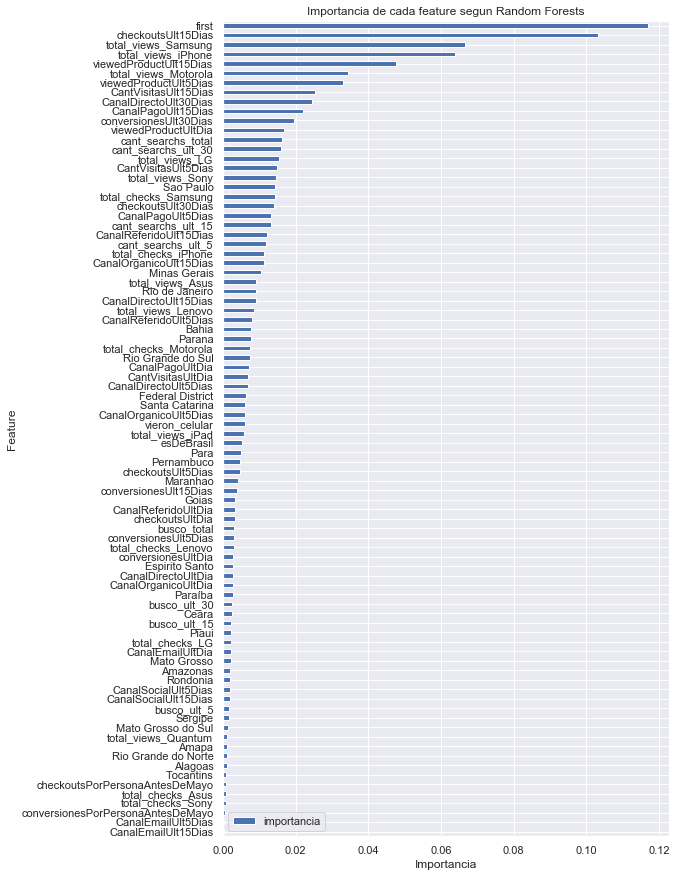

In [117]:
from sklearn.ensemble import RandomForestRegressor

sns.set(rc={'figure.figsize':(8,15)})
names = X.columns
rf = RandomForestRegressor(
    random_state=123,
    n_estimators=400,
    min_samples_split=3
)
rf.fit(X_train.values, y_train.values.ravel())
impor = np.vstack((names, rf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False).iloc[::-1]
ax = imporDf.plot(kind='barh')
ax.set_title("Importancia de cada feature segun Random Forests")
ax.set(xlabel="Importancia", ylabel="Feature")

In [111]:
from sklearn.neighbors import KNeighborsClassifier
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(X_train.values, y_train.values.ravel())

predsa = neigh.predict(X_test.values)
resultado = roc_auc_score(y_test, predsa)
print(resultado)

print("Vario: {} con respecto al anterior".format(resultado-resultado_anterior))
resultado_anterior = resultado

0.5
Vario: -0.3661980722237306 con respecto al anterior


In [107]:
X_train

,primerIngreso,ultimoIngreso,CanalDirectoUlt15Dias,checkoutsUlt15Dias,checkoutsUlt30Dias,checkoutsUlt5Dias,checkoutsUltDia,conversionesUlt30Dias,conversionesUlt15Dias,conversionesUlt5Dias,...,CanalSocialUlt5Dias,CanalSocialUltDia,CanalEmailUlt15Dias,CanalEmailUlt5Dias,CanalEmailUltDia,first,cant_searchs_ult_30,cant_searchs_ult_5,vieron_celular,regiones
person,,,,,,,,,,,,,,,,,,,,,
d26d88be,309,308,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
e99033f9,1876,4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,5.0,5.0,1.0,1.0
4c24ba21,680,35,5.0,3.0,3.0,3.0,0.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,NaN,14.0,9.0,0.0,0.0
4ebc0045,433,218,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0
be47da12,1597,287,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0
00b9f49d,150,150,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
f2e154a4,57,56,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0
b4117b5d,192,192,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,0.0,1.0
cadccad7,1851,168,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0


In [81]:
dispositivo = df.groupby('person')['screen_resolution'].value_counts().to_frame()
#dispositivo.columns = ['cant']
#dispositivo = dispositivo.reset_index()
#dispositivo = dispositivo.pivot(columns='screen_resolution', index='person', values='cant').fillna(0).rename_axis(None, axis=1)
dispositivo

,,screen_resolution
person,screen_resolution,
0008ed71,1920x1080,2
00091926,1024x768,34
00091a7a,360x640,1
000ba417,1024x768,6
000c79fe,360x640,1
000e4d9e,1536x864,13
000e619d,1024x768,5
001001be,360x640,3
0010e89a,1366x768,1


In [132]:
df["screenRes"] = obtenerRes(df['screen_resolution'])
screen = df.loc[df["screenRes"].notna(),["person", "screenRes"]].copy()
screen["screenRes"] = screen["screenRes"].astype(int)
screen["screenRes"] = np.where(screen["screenRes"].between(0,319), 200, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(320,359), 340, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(360,400), 380, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(401,600), 500, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(601,1000), 1000, screen["screenRes"])
screen["screenRes"] = np.where(screen["screenRes"].between(1000,100000), 2000, screen["screenRes"])

screen = screen.groupby('person')['screenRes'].value_counts().to_frame()
screen.columns = ['cant']
screen = screen.reset_index()
screen = screen.pivot(columns='screenRes', index='person', values='cant').fillna(0).rename_axis(None, axis=1)


,200,340,380,500,2000
person,,,,,
0008ed71,0.0,0.0,0.0,0.0,2.0
00091926,0.0,0.0,0.0,0.0,34.0
00091a7a,0.0,0.0,1.0,0.0,0.0
000ba417,0.0,0.0,0.0,0.0,6.0
000c79fe,0.0,0.0,1.0,0.0,0.0
000e4d9e,0.0,0.0,0.0,0.0,13.0
000e619d,0.0,0.0,0.0,0.0,5.0
001001be,0.0,0.0,3.0,0.0,0.0
0010e89a,0.0,0.0,0.0,0.0,1.0


In [122]:
df["device_type"].value_counts()

Smartphone    103502
Computer       97485
Tablet          2799
Unknown          283
Name: device_type, dtype: int64